# Импорт необходимых модулей

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

# На всякий случай...

[ISBN](https://en.wikipedia.org/wiki/International_Standard_Book_Number)

# Чтение данных

In [3]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

In [4]:
books = pd.read_csv('data/BX-Books.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
users = pd.read_csv('data/BX-Users.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

# Знакомство

Ок, загрузили, надо теперь поглядеть, что это вообще за данные.

In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Последние три признака не являются информативными, поскольку представляют собой ссылки на картинки обложек книг разных размеров. Их можно удалить:

In [9]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

Гдянем теперь, нет ли каких-нибудь повторений среди этих книг:

In [10]:
books_groupped = books.groupby('Book-Title').agg([np.array, len])

In [11]:
books_groupped.sort_values(by=[('ISBN', 'len')], ascending=False).head(50)

ISBN  \
                                                                                                array   
Book-Title                                                                                              
Selected Poems                                      [081120958X, 0811201465, 0679750800, 006093174...   
Little Women                                        [185854176X, 0861782356, 0590203509, 044044768...   
Wuthering Heights                                   [0553212583, 0553211412, 0812505166, 055321021...   
The Secret Garden                                   [0812505018, 0590433466, 006440188X, 059047172...   
Dracula                                             [156619301X, 055321148X, 9875021245, 014005280...   
Adventures of Huckleberry Finn                      [0835902242, 059043389X, 0451519124, 045152373...   
Jane Eyre                                           [0451518845, 0451523326, 1566193028, 156619024...   
The Night Before Christmas                          [0505523183, 0837885043, 155858465X, 030710973...   
Pride and Prejudice                                 [055321215X, 0553213105, 0451523652, 156619093...   
Great Expectations                                  [0689839618, 0140434895, 0451525248, 014130932...   
Masquerade                                          [042516019X, 0316171476, 080523747X, 082172833...   
Black Beauty                                        [0440403553, 0590423541, 1588278603, 043922890...   
Frankenstein                                        [0451511328, 0451520092, 0517118807, 840207468...   
The Gift                                            [0440221315, 0440128757, 0671702505, 038531292...   
Beloved                                             [0452280621, 0821747703, 0451161394, 844065695...   
Emma                                                [0451523067, 055321019X, 0553212737, 014025817...   
Nemesis                                             [0451200187, 0553286285, 0006170056, 045140295...   
Journey                                             [0449218473, 1592861512, 0440237025, 038531687...   
Robinson Crusoe                                     [0762414197, 0451516060, 0812504828, 045152236...   
The Secret                                          [0671744216, 0821767984, 0451186044, 052594034...   
Fahrenheit 451                                      [3257208626, 0345342968, 0345410017, 840142282...   
The Wedding                                         [0446532452, 0440236851, 0385471432, 055345555...   
Psychology                                          [0060468696, 0716751291, 1572595906, 020508177...   
Illusions                                           [0440343194, 0821746170, 0099427869, 055321859...   
Legacy                                              [0449216411, 0440147190, 0394572726, 039456432...   
Dinosaurs                                           [0307040399, 1855013150, 0860201260, 080696626...   
Hannibal                                            [0440224675, 038529929X, 3453177746, 043400940...   
Dreamcatcher                                        [0743211383, 074343627X, 0743467523, 006108325...   
The Wind in the Willows                             [0312148267, 0805002138, 1587172046, 059044774...   
Heidi                                               [0517618141, 0893754005, 0448110121, 156156455...   
Best Friends                                        [0688177026, 1573229350, 0880886595, 157322188...   
Sense and Sensibility                               [0451187903, 0451525892, 0812543122, 014043425...   
The Hobbit                                          [0345272579, 0345318587, 1594130051, 026110328...   
The Promise                                         [0786000872, 0380790963, 0449209105, 044017079...   
Carrie                                              [0451157443, 0671039725, 0451150716, 060981090...   
Phonics Fun: Reading Program, Pack 4 (Clifford ...  [0439409292, 0439409314, 0439409322, 043940934...   
Sa

Очевидно есть повторения.

Заметно, что по некоторым публикациям не указан год издания, также по некоторым книгам имена авторов по-разному указаны.

В остальном это разные издания одних и тех же работ, напечатанных в разные (не все) годы разными издательствами.

Пока не совсем понятно, что делать с этой информацией.

Попробуем глянуть, какие есть оценки для разных изданий какого-нибудь произведения:

In [12]:
ratings[ratings.ISBN.isin(books_groupped.loc['Jane Eyre', ('ISBN', 'array')])][ratings['Book-Rating'] > 0]['User-ID'].nunique()

C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


38

Итак, в частности для произведения **"Джейн Эйр"** присутствует довольно большое количество оценок от разных пользователей (для разных ISBN).

Собственно, логично предположить, что, оценивая книгу, читатель оценивает далеко не только само произведение, но еще и обложку, шрифт, цвет, качество бумаги (если это печатное издание).

Существуют, наверное и другие факторы, не имеющие отношения к самому произведению, однако здесь это особо не проверить, поскольку данных на эту тему нет.

In [13]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
ISBN                   271379 non-null object
Book-Title             271379 non-null object
Book-Author            271378 non-null object
Year-Of-Publication    271379 non-null object
Publisher              271377 non-null object
dtypes: object(5)
memory usage: 10.4+ MB


In [14]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
User-ID     278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Итак, у нас есть 271379 книг и 278858 пользователей, по книгам известны их:
- ISBN;
- название;
- автор;
- год выпуска;
- издательство.

По пользователям (не по всем) известно их:
- местоположение;
- возраст.

Надо глянуть какой процент пользователей указали возраст:

In [16]:
100 * len(users[~users.Age.isnull()]) / len(users)

60.28014258152895

Ок, ~60% пользователей не стесняются, чего не скажешь об остальных.

Глянем, как читатели распределены по возрасту:

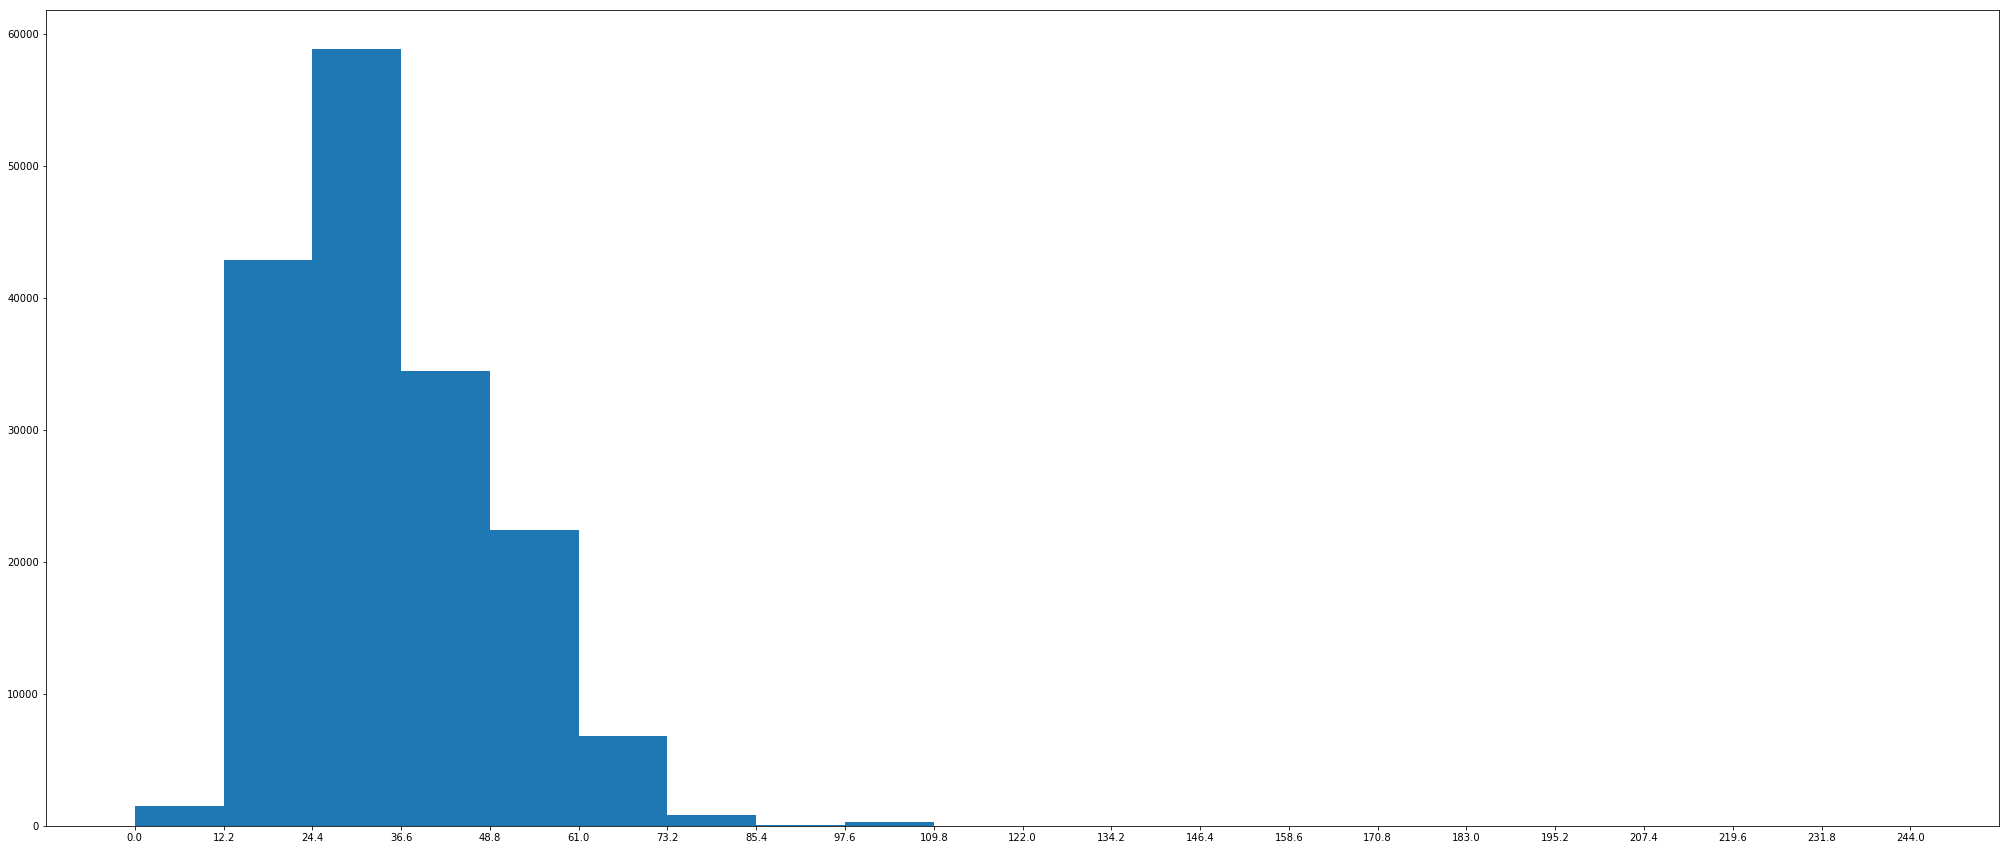

In [17]:
plt.figure(figsize=(35, 15))
n, bins, _ = plt.hist(users[~users.Age.isnull()].Age, bins=20)
plt.xticks(bins)
plt.show()

Что же, очевидно, есть некоторая часть пользователей с возрастом, указанным не вполне адекватно:

In [18]:
users[~users.Age.isnull()].Age.min()

0.0

In [19]:
users[~users.Age.isnull()].Age.max()

244.0

Вряд ли кто-то в возрасте 0 или 244 лет что-то покупал из книг.

Заметим, что поле Location состоит из трех пунктов: город, регион, страна.

Надо бы разделить это поле на три, чтобы глянуть, как пользователи по миру раскиданы.

Перед этим надо глянуть, можно ли вообще легко это разделение сделать:

In [20]:
locations = users.Location.values
locations = np.array([loc.split(', ') for loc in locations])

In [21]:
incorrect_items_more = [ind for ind, item in enumerate(locations) if len(item) > 3]
incorrect_items_less = [ind for ind, item in enumerate(locations) if len(item) < 3]

In [22]:
print(100 * (len(incorrect_items_more) + len(incorrect_items_less)) / len(locations))

2.0085491540497316


~2% людей с коряво указанными данными по местоположению.

Надо глянуть, сколько из них оценили какие-нибудь книги:

In [23]:
users_with_their_ratings_l = pd.merge(users[users.index.isin(incorrect_items_less)], ratings, how='inner', on='User-ID')

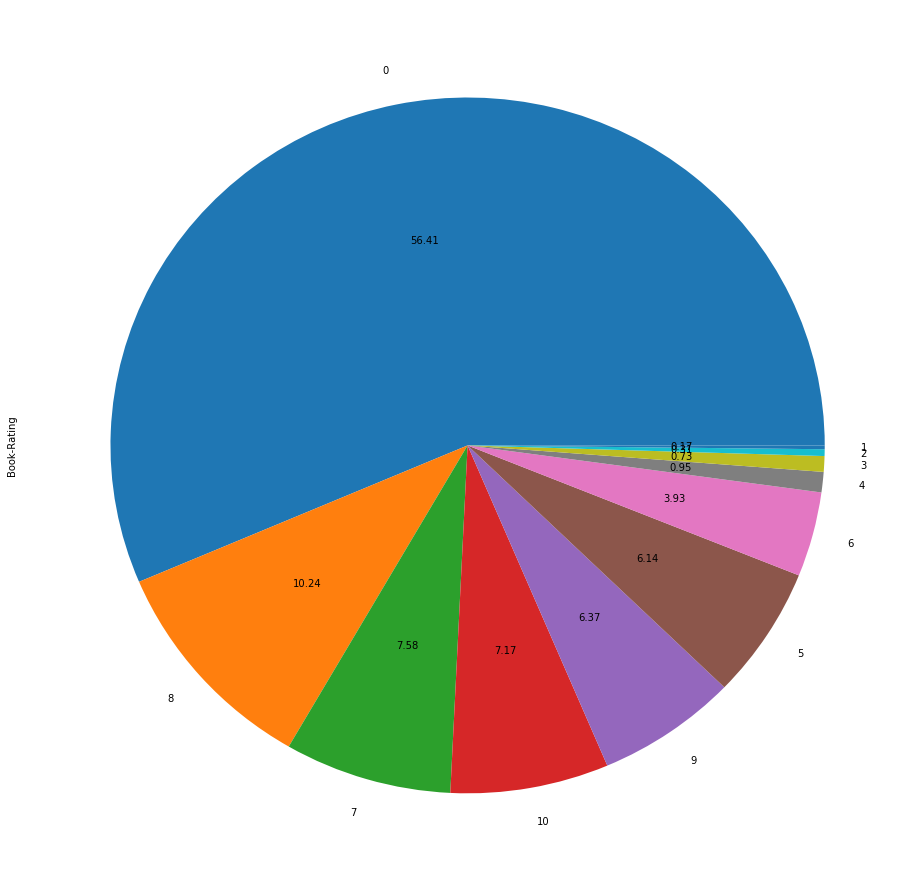

In [24]:
plt.figure(figsize=(16, 16))
users_with_their_ratings_l['Book-Rating'].value_counts().plot.pie(autopct='%.2f')
plt.show()

In [25]:
users_with_their_ratings_m = pd.merge(users[users.index.isin(incorrect_items_more)], ratings, how='inner', on='User-ID')

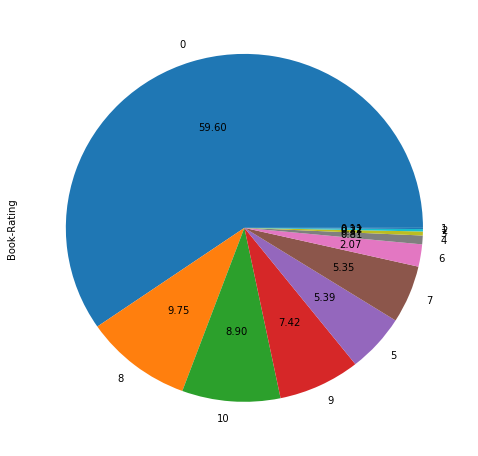

In [26]:
plt.figure(figsize=(8, 8))
users_with_their_ratings_m['Book-Rating'].value_counts().plot.pie(autopct='%.2f')
plt.show()

Здесь графики приводятся в разных масштабах, чтобы не ввести в заблуждение по поводу объема выборок пользователей с коряво указанными локациями:

In [27]:
print(len(incorrect_items_more), len(incorrect_items_less))

1024 4577


Надо бы еще глянуть, как много ISBN, указанных в таблице BX-Book-Ratings, отсутствуют в таблице BX-Books.

То же самое по поводу пользователей:

In [28]:
ratings[~ratings.ISBN.isin(books.ISBN)].ISBN.nunique()

70386

Получается, что в списке книг есть такие, о которых, вообще говоря, ничего не известно.

Надо глянуть, по скольким таким книгам есть оценки:

In [29]:
non_zero_ratings = ratings[ratings['Book-Rating'] > 0]
non_zero_ratings[~non_zero_ratings.ISBN.isin(books.ISBN)].ISBN.nunique()

36131

Что же, у нас есть оценки пользователей по книгам, о которых мы ничего не знаем.

Глянем, как это количество соотносится с общим количеством оцененных пользователями книг:

In [30]:
100 * non_zero_ratings[~non_zero_ratings.ISBN.isin(books.ISBN)].ISBN.nunique() / non_zero_ratings.ISBN.nunique()

19.42808902367548

С одной стороны 19% - это довольно много, с другой - это 19% оценок книг, о которых ничего неизвестно.

Это просто какие-то номера, по которым нельзя будет, скажем построить какой-нибудь Item-based алгоритм, после применения Collaborative filtering нельзя будет сказать, каким именно книгам были восстановлены оценки, нельзя будет сделать никаких выводов по этому поводу.

Собственно поэтому логичнее эти оценки пока не рассматривать.

In [31]:
non_zero_ratings = non_zero_ratings[non_zero_ratings.ISBN.isin(books.ISBN)]

In [32]:
non_zero_ratings.ISBN.nunique()

149842

In [33]:
non_zero_ratings[~non_zero_ratings['User-ID'].isin(users['User-ID'])]['User-ID'].nunique()

0

Итак, нет ни одного ID для которого бы в таблице users не было бы записи.

Хорошо, теперь надо еще ответить на обратные вопросы: есть ли такие пользователи, которые не дали оценки ни одной книге и есть ли такие книги, которые не были оценены ни одним пользователем:

In [34]:
100 * users[~users['User-ID'].isin(non_zero_ratings['User-ID'])]['User-ID'].nunique() / users['User-ID'].nunique()

75.58183735090978

In [35]:
100 * books[~books.ISBN.isin(non_zero_ratings.ISBN)].ISBN.nunique() / books.ISBN.nunique()

44.784968623216976

Получается, у нас есть ~75.6% пользователей, никак ни одной книги не оценивших и ~44.8% книг, никах никем не оценённых.

# К вопросу о правильном Evaluation

Здесь общая идея следующая:
- сформировать выборку троек (пользователь, книга, оценка), желательно, чтобы эта выборка покрыла как можно больше книг;
- извлечь эти тройки из основного набора данных (оценок) и далее считать, что для выбранных пользователей и книг оценки неизвестны и должны быть восстановлены;
- собственно, применить один из алгоритмов восстановления оценок;
- пользуясь выбраннной метрикой (RMSE или NDCG) оценить качество восстановления пользовательских оценок.

# Сколько читателей поставили оценки и сколько книг оценили

Ок, теперь надо глянуть, какие пользователи сколько раз поставили оценки и какие книги сколько раз были оценены.

Это необходимо для того, чтобы понять как разделять датасет на трейн и тест.

Также нужно понять какую часть пользователей и книг нужно отсеять (пользователи, оценившие слишком мало книг из всего множества, книги, оцененные слишком мало пользователями).

In [46]:
non_zero_ratings_groupped_by_user = non_zero_ratings.groupby('User-ID').agg(len)

In [47]:
non_zero_ratings_groupped_by_user.sort_values(by=['ISBN'], ascending=False).head(10)

,ISBN,Book-Rating
User-ID,,
11676,6943,6943
98391,5691,5691
189835,1899,1899
153662,1845,1845
23902,1180,1180
235105,1020,1020
76499,1012,1012
171118,962,962
16795,959,959


In [65]:
len(non_zero_ratings_groupped_by_user[non_zero_ratings_groupped_by_user.ISBN > 10])

5981

In [69]:
non_zero_ratings_groupped_by_user[non_zero_ratings_groupped_by_user.ISBN > 10].index.values

array([   242,    243,    254, ..., 278633, 278843, 278851], dtype=int64)

In [73]:
non_zero_ratings[non_zero_ratings['User-ID'] == 278633].index.values

array([9195, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206,
       9210, 9214, 9217, 9219, 9220, 9222, 9223, 9226, 9227, 9228, 9230,
       9231, 9233, 9234, 9235, 9240, 9241, 9244, 9246, 9248, 9249, 9253,
       9254, 9255, 9256, 9257, 9258, 9260, 9265, 9266, 9267, 9268], dtype=int64)

In [66]:
len(non_zero_ratings_groupped_by_user)

68092

In [48]:
non_zero_ratings_groupped_by_isbn = non_zero_ratings.groupby('ISBN').agg(len)

In [49]:
non_zero_ratings_groupped_by_isbn.sort_values(by=['User-ID'], ascending=False).head(10)

,User-ID,Book-Rating
ISBN,,
0316666343,707,707
0971880107,581,581
0385504209,487,487
0312195516,383,383
0060928336,320,320
059035342X,313,313
0142001740,307,307
0446672211,295,295
044023722X,281,281


In [67]:
len(non_zero_ratings_groupped_by_isbn[non_zero_ratings_groupped_by_isbn['User-ID'] > 10])

4788

In [68]:
len(non_zero_ratings_groupped_by_isbn)

149842